In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

# Set display options to show more columns and wider output
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Don't truncate column contents

from IPython.display import display

# Translation Deep Dive

## Loading Dataset

In [107]:
import json
import pandas as pd

# Specify the file path
file_path = "telegram_messages.json"

# Read the JSON file
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert the JSON data to a Pandas DataFrame
df = pd.json_normalize(data)

# Print the number of rows loaded
print(f"Number of rows loaded: {len(df)}")

# Remove '\n' characters from the 'message' column
df['message'] = df['message'].str.replace('\n', '', regex=False)

# Remove rows with empty or NaN 'message'
df = df.dropna(subset=['message'])  # Remove rows where 'message' is NaN
df = df[df['message'].str.strip() != '']  # Remove rows with empty or whitespace-only 'message'

# Print the number of rows after removing empty messages
print(f"Number of rows after removing empty messages: {len(df)}\n")

# Display the first few rows of the DataFrame
df.head()

Number of rows loaded: 1650
Number of rows after removing empty messages: 1546



,channel,message_id,timestamp,message,media,metadata.sender_id,metadata.message_type
0,From_hebron,272474,2024-10-18 02:06:51,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في مدينة طوباس,"[{'media_type': 'MessageMediaDocument', 'media_id': 272474}]",-1001478404564,Message
1,From_hebron,272471,2024-10-18 01:35:45,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحيى السنوار توجه إلى باب العامود في القدس وحاول توزيع الحلوى على الفلسطينيين,"[{'media_type': 'MessageMediaDocument', 'media_id': 272471}]",-1001478404564,Message
2,From_hebron,272470,2024-10-18 01:29:18,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا مصدق .. الحزن داخلي لساته .. قهر ونكد وفش نفس لأي اشي ..هاد حال كل شريف الان,[],-1001478404564,Message
3,From_hebron,272469,2024-10-18 01:29:01,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق وسط مدينة خانيونس,"[{'media_type': 'MessageMediaDocument', 'media_id': 272469}]",-1001478404564,Message
4,From_hebron,272468,2024-10-18 01:22:14,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلال منزلاً في مخيم الشاطئ غربي مدينة غزة,[],-1001478404564,Message


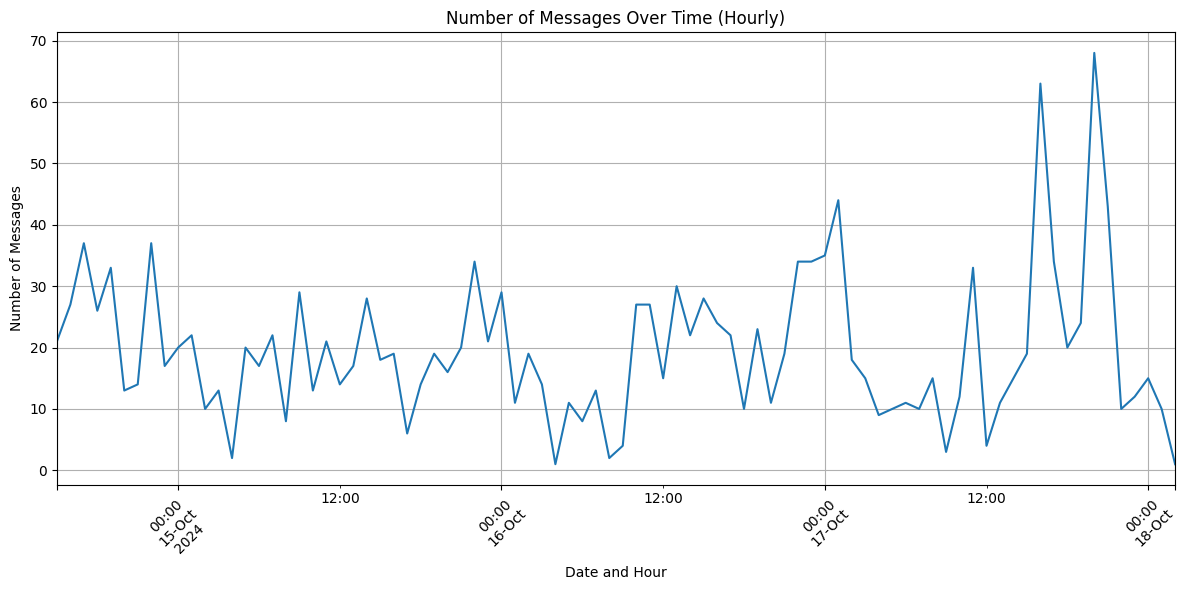

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group the data by hourly intervals and count the number of messages
message_counts = df.groupby(df['timestamp'].dt.floor('H'))['message'].count()

# Plot the result
plt.figure(figsize=(12, 6))
message_counts.plot(kind='line')
plt.title('Number of Messages Over Time (Hourly)')
plt.xlabel('Date and Hour')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to avoid label cutoff
plt.show()

## Comparing GPT to Google Translation Pricing

In [47]:
from cost_calculator import CostCalculator

def compare_gpt_vs_google_translate(df, gpt_model_name, google_translate_price_per_million_chars=20, google_translate_batch_size=1_000_000):
    # Calculate the total number of characters in the 'message' column
    total_chars = df['message'].str.len().sum()

    # Display the total number of characters
    print(f"Total number of characters in the 'message' column: {total_chars}")

    # Calculate the total price for Google Translate (rounded to 2 decimal places)
    google_translate_cost = round((total_chars / google_translate_batch_size) * google_translate_price_per_million_chars, 2)
    print(f"Total price to translate in Google Translate: {google_translate_cost}$\n")

    # Concatenate all messages into a single string
    all_messages = df['message'].str.cat(sep=' ')

    # Initialize the cost calculator for GPT
    gpt_calc = CostCalculator(gpt_model_name)

    # Calculate the prompt and completion costs (rounded to 2 decimal places)
    prompt_cost = round(gpt_calc.calculate_prompt_cost(all_messages), 2)
    completion_cost = round(gpt_calc.calculate_completion_cost(all_messages), 2)
    print()

    # Display the calculated costs
    print(f"{gpt_model_name} Prompt cost: {prompt_cost}$")
    print(f"{gpt_model_name} Completion cost: {completion_cost}$")

    # Calculate the total GPT cost and display it (rounded to 2 decimal places)
    total_gpt_cost = round(prompt_cost + completion_cost, 2)
    print(f"Total cost: {total_gpt_cost}$\n")

    # Calculate and display how much cheaper GPT is than Google Translate (rounded to 2 decimal places)
    savings = round(google_translate_cost - total_gpt_cost, 2)
    percentage_savings = round((savings / google_translate_cost) * 100, 2)

    print(f"{gpt_model_name} is cheaper than Google Translate by: {savings}$ ({percentage_savings}% less)")

In [48]:
compare_gpt_vs_google_translate(df, "gpt-4o-2024-08-06")

Total number of characters in the 'message' column: 183336
Total price to translate in Google Translate: 3.67$

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'

gpt-4o-2024-08-06 Prompt cost: 0.16$
gpt-4o-2024-08-06 Completion cost: 0.64$
Total cost: 0.8$

gpt-4o-2024-08-06 is cheaper than Google Translate by: 2.87$ (78.2% less)


In [35]:
compare_gpt_vs_google_translate(df, "gpt-4o-mini-2024-07-18")

Total number of characters in the 'message' column: 183336
Total price to translate in Google Translate: 3.67$

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-mini-2024-07-18'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-mini-2024-07-18'

gpt-4o-mini-2024-07-18 Prompt cost: 0.01$
gpt-4o-mini-2024-07-18 Completion cost: 0.04$
Total cost: 0.05$

gpt-4o-mini-2024-07-18 is cheaper than Google Translate by: 3.62$ (98.64% less)


<mark>Keep in mind that I did not take into account the prompting needed for translation.</mark>

## Translating with GPT4o, GPT4o-mini and Google Translate

In [93]:
compare_df = pd.DataFrame(df['message'].copy()).head(100)
compare_df.head()

,message
0,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في مدينة طوباس
1,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحيى السنوار توجه إلى باب العامود في القدس وحاول توزيع الحلوى على الفلسطينيين
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا مصدق .. الحزن داخلي لساته .. قهر ونكد وفش نفس لأي اشي ..هاد حال كل شريف الان
3,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق وسط مدينة خانيونس
4,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلال منزلاً في مخيم الشاطئ غربي مدينة غزة


### GPT-4o

In [95]:
import pandas as pd
from typing import List, Dict
from pydantic import BaseModel
from openai_client import OpenAIClient
from tqdm import tqdm

# Response models that did not worked and delayed me
# class TranslationResponse(BaseModel):
#     """Response model for individual translations."""
#     hebrew: str
#     english: str

# class BatchTranslationResponse(BaseModel):
#     """Response model for batch translations."""
#     translations: Dict[int, TranslationResponse]

# Define response models
class TranslationResponse(BaseModel):
    """Response model for individual translations."""
    hebrew: str
    english: str

class NumberedTranslation(BaseModel):
    """Model associating a number with a translation."""
    number: int  # Explicit field for the number
    translation: TranslationResponse  # Translation details

class BatchTranslationResponse(BaseModel):
    """Response model for batch translations."""
    translations: List[NumberedTranslation]


# Translator class that interacts with OpenAI's API
class MessageTranslator:
    def __init__(self, client: OpenAIClient):
        self.client = client

    def translate_batch(self, messages: List[str]) -> BatchTranslationResponse:
        """Translate a batch of up to 10 messages."""
        system_message = """
        Act as a highly accurate translator. Your task is to take a batch of Arabic messages from a Telegram group and translate each into both 
        Hebrew and English. Each message is numbered from 1 to 10.

        Ensure that for each message:
        - All emojis and decorative symbols are removed before translation.
        - Translations are precise and maintain the original meaning, tone, and nuance.
        - Military, organizational, or specific terminology is translated consistently.
        - Clarity and natural phrasing are prioritized in both Hebrew and English.
        - Punctuation and formatting are retained accurately.
        - Urgency and emotional tone are maintained naturally and fluently.

        Respond with a JSON object where each key is the message number, and the value is an object with 'hebrew' and 'english' translations.
        """

        user_message = "\n".join([f"{i+1}. {msg}" for i, msg in enumerate(messages)])

        # API call to translate the batch of messages
        response = self.client.chat(
            system_message=system_message,
            user_message=user_message,
            response_format=BatchTranslationResponse,
            max_completion_tokens=3000
        )

        if response is None:
            raise ValueError("Received an empty response from the API.")
        
        return response  # Already parsed as BatchTranslationResponse


# Handle DataFrame processing and translation batching
class DataFrameProcessor:
    def __init__(self, translator: MessageTranslator, batch_size: int = 10):
        """Initialize with a translator and batch size."""
        self.translator = translator
        self.batch_size = batch_size

    def process_dataframe(self, df: pd.DataFrame, column_name: str) -> pd.DataFrame:
        """Process a DataFrame column in batches and add translation columns."""
        messages = df[column_name].tolist()
        all_translations = {}

        # Process the DataFrame in batches of the specified size
        for i in tqdm(range(0, len(messages), self.batch_size), desc="Processing batches"):
            batch = messages[i:i + self.batch_size]
            
            try:
                batch_response = self.translator.translate_batch(batch)
                for item in batch_response.translations:
                    all_translations[i + item.number] = item.translation
            except Exception as e:
                print(f"Error processing batch {i // self.batch_size + 1}: {e}")
        
        # Add the translations back to the DataFrame
        df['hebrew_translation'] = df.index.map(lambda x: all_translations.get(x + 1, TranslationResponse(hebrew="", english="")).hebrew)
        df['english_translation'] = df.index.map(lambda x: all_translations.get(x + 1, TranslationResponse(hebrew="", english="")).english)
        
        return df



# Usage example
if __name__ == "__main__":
    openai_client = OpenAIClient()  # Assume OpenAIClient is correctly implemented
    translator = MessageTranslator(openai_client)
    processor = DataFrameProcessor(translator, batch_size=15)

    # Process DataFrame and print it
    compare_df = processor.process_dataframe(compare_df, 'message')

    # Renaming the columns
    compare_df.rename(columns={
        'hebrew_translation': 'gpt-4o.hebrew_translation',
        'english_translation': 'gpt-4o.english_translation'
    }, inplace=True)

    # Print the total costs of OpenAI calls
    openai_client.print_total_costs()

    # Display the updated DataFrame with translations
    display(compare_df.head(5))

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'


Processing batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:11<00:00, 10.24s/it]

Total prompt cost: $0.013070
Total completion cost: $0.074480
Overall total cost: $0.087550


,message,gpt-4o.hebrew_translation,gpt-4o.english_translation
0,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في مدينة طوباس,מקורות מקומיים: ירי לעבר כוחות הכיבוש בעיר טובאס,Local sources: Gunfire confrontation with occupation forces in the city of Tubas
1,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحيى السنوار توجه إلى باب العامود في القدس وحاول توزيع الحلوى على الفلسطينيين,"כתב ישראלי קיצוני רצה לחגוג את ההתנקשות ביהיא סנוואר, הגיע לשער שכם וניסה לחלק ממתקים לפלסטינים","An extremist Israeli journalist wanted to celebrate the assassination of Yahya Sinwar, went to Damascus Gate in Jerusalem, and tried to distribute sweets to Palestinians"
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا مصدق .. الحزن داخلي لساته .. قهر ونكد وفش نفس لأي اشي ..هاد حال كل شريف الان,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה ואיש לא מאמין .. העצב עדיין בתוכי .. כעס ודכאון ואין נשימה לכלום .. כך מצבו של כל אדם כנה כעת,The weather is gloomy .. the breathing is heavy .. a lot of thinking and no one believes .. the sadness is still inside .. frustration and gloom and there's no breath for anything .. that's the state of every honest person now
3,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق وسط مدينة خانيونس,מקורות מקומיים: ריחוף מסיבי של מטוסי סיור מעל מרכז העיר ח'אן יונס,Local sources: Intensive flight of reconnaissance planes over the center of Khan Yunis
4,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلال منزلاً في مخيم الشاطئ غربي مدينة غزة,מקורות מקומיים: הרוגים ופצועים בהפגזת מטוסי הכיבוש על בית במחנה השאטי מערבית לעיר עזה,Local sources: Martyrs and injuries in the bombing of an occupation plane on a house in the Shati refugee camp west of Gaza City


### GPT-4o mini

In [96]:
if __name__ == "__main__":
    openai_client = OpenAIClient(model="gpt-4o-mini-2024-07-18")
    translator = MessageTranslator(openai_client)
    processor = DataFrameProcessor(translator, batch_size=15)

    # Process DataFrame and print it
    compare_df = processor.process_dataframe(compare_df, 'message')

    # Renaming the columns
    compare_df.rename(columns={
        'hebrew_translation': 'gpt-4o-mini.hebrew_translation',
        'english_translation': 'gpt-4o-mini.english_translation'
    }, inplace=True)

    # Print the total costs of OpenAI calls
    openai_client.print_total_costs()

    # Display the updated DataFrame with translations
    display(compare_df.head(5))

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-mini-2024-07-18'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-mini-2024-07-18'


Processing batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.85s/it]

Total prompt cost: $0.000784
Total completion cost: $0.005304
Overall total cost: $0.006088


,message,gpt-4o.hebrew_translation,gpt-4o.english_translation,gpt-4o-mini.hebrew_translation,gpt-4o-mini.english_translation
0,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في مدينة طوباس,מקורות מקומיים: ירי לעבר כוחות הכיבוש בעיר טובאס,Local sources: Gunfire confrontation with occupation forces in the city of Tubas,מקורות מקומיים: חילופי אש עם כוחות הכיבוש בעיר טובאס,Local sources: Armed clashes with occupation forces in the city of Tubas
1,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحيى السنوار توجه إلى باب العامود في القدس وحاول توزيع الحلوى على الفلسطينيين,"כתב ישראלי קיצוני רצה לחגוג את ההתנקשות ביהיא סנוואר, הגיע לשער שכם וניסה לחלק ממתקים לפלסטינים","An extremist Israeli journalist wanted to celebrate the assassination of Yahya Sinwar, went to Damascus Gate in Jerusalem, and tried to distribute sweets to Palestinians",עיתונאי ישראלי קיצוני רצה לחגוג את חיסולו של יחיא סנואר ופנה לשער שכם בירושלים וניסה לחלק ממתקים לפלסטינים,"An extremist Israeli journalist wanted to celebrate the assassination of Yahya Sinwar, headed to the Damascus Gate in Jerusalem, and tried to distribute sweets to Palestinians"
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا مصدق .. الحزن داخلي لساته .. قهر ونكد وفش نفس لأي اشي ..هاد حال كل شريف الان,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה ואיש לא מאמין .. העצב עדיין בתוכי .. כעס ודכאון ואין נשימה לכלום .. כך מצבו של כל אדם כנה כעת,The weather is gloomy .. the breathing is heavy .. a lot of thinking and no one believes .. the sadness is still inside .. frustration and gloom and there's no breath for anything .. that's the state of every honest person now,המזג אוויר מדכא.. הנשמה צרה.. יש חשיבה רבה ולאף אחד לא מאמין.. העצב פנימי עדיין.. תסכול ועצב ואין כוח לכלום.. זה המצב של כל אדם ישר כרגע,The weather is gloomy.. the soul is tight.. there is a lot of thinking and no one believes.. the sadness is still internal.. frustration and misery and no energy for anything.. that's the state of every honorable person now
3,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق وسط مدينة خانيونس,מקורות מקומיים: ריחוף מסיבי של מטוסי סיור מעל מרכז העיר ח'אן יונס,Local sources: Intensive flight of reconnaissance planes over the center of Khan Yunis,מקורות מקומיים: טיסה אינטנסיבית של מטוסי ריגול מעל מרכז העיר חאן יونس,Local sources: Intense flights of reconnaissance planes over the city center of Khan Younis
4,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلال منزلاً في مخيم الشاطئ غربي مدينة غزة,מקורות מקומיים: הרוגים ופצועים בהפגזת מטוסי הכיבוש על בית במחנה השאטי מערבית לעיר עזה,Local sources: Martyrs and injuries in the bombing of an occupation plane on a house in the Shati refugee camp west of Gaza City,מקורות מקומיים: שורדים ונפגעים בהפצצת מטוסי הכיבוש על בית במחנה הפליטים אלשאטי מערבית לעיר עזה,Local sources: Martyrs and injured in the bombing of occupation planes on a house in the al-Shati refugee camp west of Gaza City


### Google Translate

In [112]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from google_trn import TranslationService

# Function to translate a message and return the Hebrew and English translations
def translate_message(message, translator_hebrew, translator_english):
    try:
        # Translate to Hebrew
        hebrew_translation = translator_hebrew.translate(message)
        
        # Translate to English
        english_translation = translator_english.translate(message)
        
        return hebrew_translation, english_translation
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return None, None

# Function to process the DataFrame in parallel
def process_translations(df):
    # Initialize translation services for Hebrew and English
    translator_hebrew = TranslationService(source_lang="ar", target_lang="he")  # Arabic to Hebrew
    translator_english = TranslationService(source_lang="ar", target_lang="en")  # Arabic to English

    # Initialize a ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        # Map the translation function to the 'message' column
        results = list(executor.map(
            lambda message: translate_message(message, translator_hebrew, translator_english),
            df['message']
        ))
    
    # Separate the results into Hebrew and English translations
    hebrew_translations, english_translations = zip(*results)

    # Add new columns to the DataFrame
    df['google-translate.hebrew_translation'] = hebrew_translations
    df['google-translate.english_translation'] = english_translations

    # Print cost
    translator_english.print_total_costs()
    translator_hebrew.print_total_costs()

    return df

# Example usage
if __name__ == "__main__":

    # Process the translations in parallel
    df_translated = process_translations(compare_df)

    # Display the updated DataFrame
    display(df_translated.head())

Loading environment variables...
Using credentials from: teak-ellipse-401213-fba00a21f05d.json
Loaded project ID: teak-ellipse-401213
TranslationServiceClient initialized successfully.
Source language: ar, Target language: he
Loading environment variables...
Using credentials from: teak-ellipse-401213-fba00a21f05d.json
Loaded project ID: teak-ellipse-401213
TranslationServiceClient initialized successfully.
Source language: ar, Target language: en
Total characters translated: 11170
Total accumulated cost: $0.223400
Total characters translated: 11170
Total accumulated cost: $0.223400


,message,gpt-4o.hebrew_translation,gpt-4o.english_translation,gpt-4o-mini.hebrew_translation,gpt-4o-mini.english_translation,google-translate.hebrew_translation,google-translate.english_translation
0,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في مدينة طوباس,מקורות מקומיים: ירי לעבר כוחות הכיבוש בעיר טובאס,Local sources: Gunfire confrontation with occupation forces in the city of Tubas,מקורות מקומיים: חילופי אש עם כוחות הכיבוש בעיר טובאס,Local sources: Armed clashes with occupation forces in the city of Tubas,🛑מקורות מקומיים: עימותים חמושים עם כוחות הכיבוש בעיר טובאס,🛑Local sources: Armed clashes with the occupation forces in the city of Tubas
1,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحيى السنوار توجه إلى باب العامود في القدس وحاول توزيع الحلوى على الفلسطينيين,"כתב ישראלי קיצוני רצה לחגוג את ההתנקשות ביהיא סנוואר, הגיע לשער שכם וניסה לחלק ממתקים לפלסטינים","An extremist Israeli journalist wanted to celebrate the assassination of Yahya Sinwar, went to Damascus Gate in Jerusalem, and tried to distribute sweets to Palestinians",עיתונאי ישראלי קיצוני רצה לחגוג את חיסולו של יחיא סנואר ופנה לשער שכם בירושלים וניסה לחלק ממתקים לפלסטינים,"An extremist Israeli journalist wanted to celebrate the assassination of Yahya Sinwar, headed to the Damascus Gate in Jerusalem, and tried to distribute sweets to Palestinians",📍עיתונאי ישראלי קיצוני שביקש לחגוג את רצח יחיא סינוואר יצא לשער דמשק בירושלים וניסה לחלק ממתקים לפלסטינים.,📍An extremist Israeli journalist who wanted to celebrate the assassination of Yahya Sinwar went to Bab al-Amoud in Jerusalem and tried to distribute sweets to the Palestinians
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا مصدق .. الحزن داخلي لساته .. قهر ونكد وفش نفس لأي اشي ..هاد حال كل شريف الان,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה ואיש לא מאמין .. העצב עדיין בתוכי .. כעס ודכאון ואין נשימה לכלום .. כך מצבו של כל אדם כנה כעת,The weather is gloomy .. the breathing is heavy .. a lot of thinking and no one believes .. the sadness is still inside .. frustration and gloom and there's no breath for anything .. that's the state of every honest person now,המזג אוויר מדכא.. הנשמה צרה.. יש חשיבה רבה ולאף אחד לא מאמין.. העצב פנימי עדיין.. תסכול ועצב ואין כוח לכלום.. זה המצב של כל אדם ישר כרגע,The weather is gloomy.. the soul is tight.. there is a lot of thinking and no one believes.. the sadness is still internal.. frustration and misery and no energy for anything.. that's the state of every honorable person now,"🛑 מזג האוויר קודר.. הנשמה קצרה.. חושבים הרבה ואף אחד לא מאמין בזה.. העצב בתוכי עדיין שם.. דיכוי, מצוקה, וחוסר נשימה לכל דבר.. זה המצב של כל אדם נכבד עכשיו.","🛑The atmosphere is gloomy.. The soul is tight.. Thinking a lot and no one believes me.. The sadness is still inside me.. Oppression, depression and lack of desire for anything.. This is the state of every honorable person now."
3,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق وسط مدينة خانيونس,מקורות מקומיים: ריחוף מסיבי של מטוסי סיור מעל מרכז העיר ח'אן יונס,Local sources: Intensive flight of reconnaissance planes over the center of Khan Yunis,מקורות מקומיים: טיסה אינטנסיבית של מטוסי ריגול מעל מרכז העיר חאן יونس,Local sources: Intense flights of reconnaissance planes over the city center of Khan Younis,🛑מקורות מקומיים: טיסה אינטנסיבית של מטוסי סיור מעל מרכז חאן יונס,🛑Local sources: Intensive flights of reconnaissance aircraft over the center of Khan Yunis city
4,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلال منزلاً في مخيم الشاطئ غربي مدينة غزة,מקורות מקומיים: הרוגים ופצועים בהפגזת מטוסי הכיבוש על בית במחנה השאטי מערבית לעיר עזה,Local sources: Martyrs and injuries in the bombing of an occupation plane on a house in the Shati refugee camp west of Gaza City,מקורות מקומיים: שורדים ונפגעים בהפצצת מטוסי הכיבוש על בית במחנה הפליטים אלשאטי מערבית לעיר עזה,Local sources: Martyrs and injured in the bombing of occupation planes on a house in the al-Shati refugee camp west of Gaza City,"🛑מקורות מקומיים: אנוסים ונפצעו כשמטוסי כיבוש הפציצו בית במחנה אלשאטי, ממערב ל

### Saving df to csv File

In [133]:
df_translated.to_csv('top_100_translated.csv', index=False)

### Cost Comparison

How many messages can be sent for each service with $1:

- **GPT-4o**: 1,142 messages
- **GPT-4o Mini**: 16,425 messages
- **Google Translate**: 223 messages

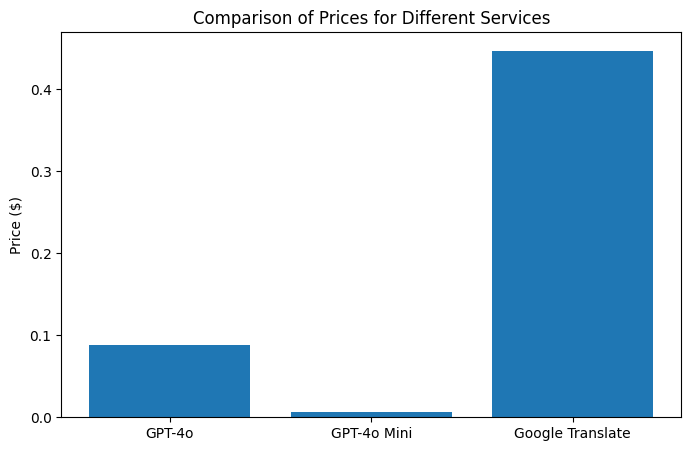

In [121]:
import matplotlib.pyplot as plt

# Data for the bar plot
services = ['GPT-4o', 'GPT-4o Mini', 'Google Translate']
prices = [0.087550, 0.006088, 0.4468]

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(services, prices)

# Add labels and title
plt.ylabel('Price ($)')
plt.title('Comparison of Prices for Different Services')

# Display the plot
plt.show()